The purpose of this section of the capstone project is to model the car data that has been prepared and determine which model would perform best as a predictor of car price.  To recap, the following variables have all been show to be statistically significant in affecting car price, and so they will all be taken into account in the models:

Year <br>
Manufacturer <br>
Number of Cylinders <br>
Odometer <br>
Transmission <br>
Drive <br>
Paint Color <br>
State

In the previous part of the project, the data had already been put into training (%70) and testing sets(%30), and dummy variables have been assigned to all of the categorical variables, so all that is left to do is model the data.  The three models that I am using are Random Forest, AdaBoost, and Gradient Boosting.  They are all three ensemble methods that all use trees to split data, which is useful since I did not scale the data.

Since this is a regression model, I am ranking the performance of the data on three key factors, root mean squared error, mean absolute error and adjusted r squared.  These are commonly accepted as among the most important factors in determining model effectiveness for regression.  I am also taking into account the time it takes to fit each model, which could be a big factor if someone wants quick results.

First I will import any models that I might use.  I will likely not use all of them.

In [66]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import statsmodels.api as sm
import time

Now to import the data and look at it to make sure it is ready to model.

In [2]:
cars = pd.read_csv('cars.csv', index_col=0)
X_train = pd.read_csv('cars_x_train.csv', index_col=0)
X_test = pd.read_csv('cars_x_test.csv', index_col=0)
y_train = pd.read_csv('cars_y_train.csv', index_col=0)
y_test = pd.read_csv('cars_y_test.csv', index_col=0)

cars.head()

,id,price,year,manufacturer,model,cylinders,odometer,transmission,drive,paint_color,state
1,7184773187,8750,2013.0,hyundai,sonata,4 cylinders,90821.0,automatic,fwd,grey,MN
2,7193375964,10900,2013.0,toyota,prius,4 cylinders,92800.0,automatic,fwd,blue,CT
6,7184710887,7995,2010.0,chevrolet,equinox,4 cylinders,108124.0,automatic,4wd,grey,MN
14,7184705759,10995,2008.0,chevrolet,tahoe,Unknown,143528.0,automatic,4wd,grey,MN
17,7184703651,14995,2011.0,chevrolet,silverado 1500,8 cylinders,102462.0,automatic,4wd,blue,MN


In [3]:
X_train.shape, X_test.shape

((128459, 118), (55055, 119))

I immediately notice a small problem.  The column sizes are different, which means there is a variable in the test set that is not in the training set.  I need to determine what it is.

In [12]:
set(X_test.columns).difference(X_train.columns)

{'morgan'}

I did research and found out this was indeed a car type.  However, the model would not run on the training set because the number of columns are different.  I will have to drop this column to make sure they are the same.

In [13]:
X_test = X_test.drop('morgan',axis=1)
X_train.shape, X_test.shape

((128459, 118), (55055, 118))

In [4]:
y_train.shape, y_test.shape

((128459, 1), (55055, 1))

Now it's time for modeling <br>
I want to run cross validation on all the training sets to get an idea of the best hyperparameters that I can use the maximize the effectiveness of my model.  For each of my models, I will use GridSearchCV for this, and I will pick three hyperparameters that are often accepted as the most important, as well as three options for each hyperparameter.


The first model I will use Random Forest<br> 
The three hyperparameters I will focus on are: <br>
n_estimators-number of trees in the forest<br>
max_features- max number of features considered for splitting a node<br>
max_depth- max number of levels in each decision tree.  

In [6]:
rf = RandomForestRegressor()
param = {'n_estimators':[50,100,200],'max_depth':[30,60,90], 'max_features':[5,7,9]}
gs = GridSearchCV(rf, param, cv=3, n_jobs=-1)
gs.fit(X_train,y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30, 60, 90], 'max_features': [5, 7, 9],
                         'n_estimators': [50, 100, 200]})

In [7]:
gs.best_params_

{'max_depth': 60, 'max_features': 9, 'n_estimators': 200}

From the options I gave, the model determined that the best hyperparameters are a max depth of 60, 9 max features, and 200 estimators.  I will now use these to fit and train my model, also timing to see how long it takes to predict on new models.

In [25]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=60,max_features=9)
model_res = rfr.fit(X_train, y_train)
startrf=time.time()
y_pred = model_res.predict(X_test)
endrf=time.time()
rf_pred_time = (endrf-startrf)
rf_pred_time

<ipython-input-25-c261021ee242>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_res = rfr.fit(X_train, y_train)


16.23550844192505

The time taken was a little over 16 seconds.  Now I will compare the predicted y values to the actual y values using root mean squared error and mean absolute error.  I will also find the adjusted r squared.  To do this I need to find the r squared then put it in the formula for determining adjusted r squared.  I will come back to this information after I ran all of my models to compare.

In [18]:
rand_for_rmse = sqrt(mean_squared_error(y_test,y_pred))
rand_for_rmse

5315.731003727275

In [67]:
rand_for_mae = mean_absolute_error(y_test,y_pred)
rand_for_mae

2865.730840535116

In [20]:
rand_for_rsq = r2_score(y_test,y_pred)
rand_for_rsq

0.8272768067406069

In [21]:
rand_for_adjrsq = (1-(1-rand_for_rsq)*((len(X_test)-1)/(len(X_test)-9-1)))
rand_for_adjrsq

0.8272485660513648

The next model I will use is Adaboost<br>
The three hyperparameters I will focus on are: <br>
n_estimators - The maximum number of estimators at which boosting is terminated<br>
learning-rate - shrinks the contribution of each classifier by learning_rate<br>
loss - the loss function to use when updating the weights after each boosting iteration.

I will follow all of the same procedures as the previous model.

In [22]:
ar = AdaBoostRegressor()
param_ada = {
 'n_estimators': [50, 100, 150],
 'learning_rate' : [0.01,0.05,0.1],
 'loss' : ['linear', 'square', 'exponential']
 }
gsa = GridSearchCV(ar, param_ada, cv=3, n_jobs=-1)
gsa.fit(X_train,y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 150]})

In [23]:
gsa.best_params_

{'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 50}

From the options I gave, the model determined that the best hyperparameters are a learning rate of 0.05, an exponential loss function, and 50 estimators.  I will now use these to fit and train my model, also timing to see how long it takes to predict on new models.

In [34]:
abr = AdaBoostRegressor(n_estimators=50,learning_rate=0.05,loss="exponential")
modelada= abr.fit(X_train, y_train)
startab=time.time()
y_pred_ab = modelada.predict(X_test)
endab=time.time()
ab_pred_time = (endab-startab)
ab_pred_time

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3.970144510269165

The time taken was a little less than 4 seconds. I will calculate rmse, mae, and adjusted r squared as before. I will come back to this information after I ran all of my models to compare.

In [35]:
ab_rmse = sqrt(mean_squared_error(y_test,y_pred_ab))
ab_rmse

9366.062196965706

In [68]:
ab_mae = mean_absolute_error(y_test,y_pred_ab)
ab_mae

6502.514551071933

In [36]:
ab_rsq = r2_score(y_test,y_pred_ab)
ab_rsq

0.46378526792393193

In [37]:
ab_adjrsq = (1-(1-ab_rsq)*((len(X_test)-1)/(len(X_test)-9-1)))
ab_adjrsq

0.46369759542708966

The final model that I will use is Gradient Boosting<br>
The three hyperparameters that I will focus on are:<br>
n_estimators - the number of boosting stages to perform<br>
learning_rate - shrinks the contribution of each tree by learning_rate<br>
max_depth - maximum depth of the individual regression estimators

I will follow the same procedure as with the previous models.

In [32]:
gb = GradientBoostingRegressor()
param_gb = {
    'n_estimators':[50,100,200],
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[2,4,6]
}
gsg = GridSearchCV(gb, param_gb, cv=3, n_jobs=-1)
gsg.fit(X_train,y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]})

In [33]:
gsg.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

From the options I gave, the model determined that the best hyperparameters are a learning rate of 0.1, a max depth of 6, and 200 estimators.  I will now use these to fit and train my model, also timing to see how long it takes to predict on new models.

In [39]:
gbr = GradientBoostingRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
model_gb = gbr.fit(X_train,y_train)
startgb = time.time()
y_pred_gb = model_gb.predict(X_test)
endgb = time.time()
gb_pred_time = (endgb - startgb)
gb_pred_time

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1.3992550373077393

The time taken was about 1.4 seconds.  Now I will get the rmse, mae, and adjusted r squared as before, then compare all the data.

In [40]:
gb_rmse = sqrt(mean_squared_error(y_test,y_pred_gb))
gb_rmse

6674.371283015928

In [69]:
gb_mae = mean_absolute_error(y_test,y_pred_gb)
rand_for_mae

2865.730840535116

In [41]:
gb_rsq = r2_score(y_test,y_pred_gb)
gb_rsq

0.7277014110891817

In [42]:
gb_adjrsq = (1-(1-gb_rsq)*((len(X_test)-1)/(len(X_test)-9-1)))
gb_adjrsq

0.7276568895649707

It is now time to compare my results.  There were not many data points that we were using, but it is still nice to see them graphically.  The first thing I will compare is the time it took for each model to make a prediction.  This could be an important factor if customers are wanting fast results.

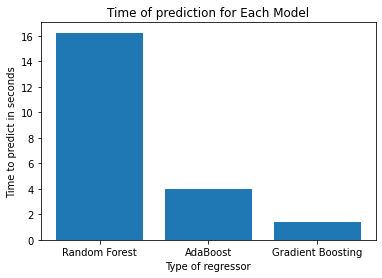

In [59]:
all_times = [rf_pred_time, ab_pred_time, gb_pred_time]
labels = ['Random Forest', 'AdaBoost', 'Gradient Boosting']
fig,ax = plt.subplots()
time_bar = ax.bar(labels,all_times)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('Time to predict in seconds')
ax.set_title('Time of prediction for Each Model')
plt.show()

The time difference between random forest and the two boosting models was significant, taking almost four times as long as the next longest variable.  Gradient boosting was by far the fastest predictor.

Now we will compare the square root of the error of each model.  A lower score means that the predictions were closer to the actual values.

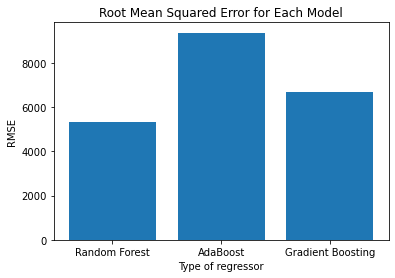

In [64]:
all_rmse = [rand_for_rmse, ab_rmse, gb_rmse]
fig,ax = plt.subplots()
rmse_bar = ax.bar(labels,all_rmse)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('RMSE')
ax.set_title('Root Mean Squared Error for Each Model')
plt.show()

While random forest took much longer to predict, it had the best results with the smallest RMSE.  Gradient boosting had higher RMSE, but AdaBoost was significantly higher.  RMSE is usually considered the most important factors in determining regression model effectiveness, so AdaBoost is likely eliminated as the best model.

The next graph we will look at mean absolute error, which also has a lower score being better.

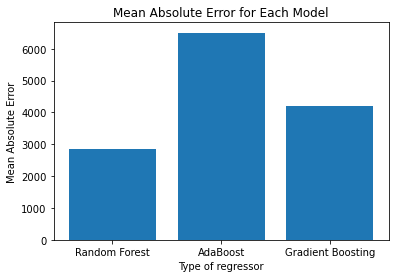

In [70]:
all_mae = [rand_for_mae, ab_mae, gb_mae]
fig,ax = plt.subplots()
adjsqr_bar = ax.bar(labels,all_mae)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Mean Absolute Error for Each Model')
plt.show()

Random forest had the best MAE score, with AdaBoost scoring the lowest.  This coincides fairly well with the RMSE.

The final graph that we will use for prediction is adjusted r squared, which generally is better at scoring at r squared because it takes into account the number of variables used.  Unlike RMSE and MAE, a higher score is considered better.

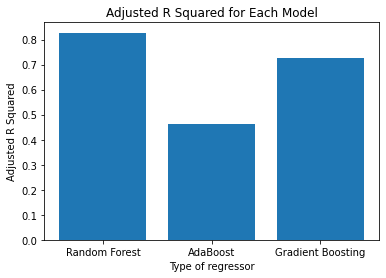

In [65]:
all_mae = [rand_for_adjrsq, ab_adjrsq, gb_adjrsq]
fig,ax = plt.subplots()
adjsqr_bar = ax.bar(labels,all_adjrsq)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('Adjusted R Squared')
ax.set_title('Adjusted R Squared for Each Model')
plt.show()

Once again random forest scored the best, followed closely by gradient boosting.  AdaBoost was a much lower score, and its time was worse than gradient boosting, so for this project, it can be eliminated as the best option.

The final question comes down to what model was the best performer for predicting vehicle price based on the variables given.  If I did not take into account time taken to make a prediction, Random Forest easily scored the best.  However, when taking into account time, it took over 16 seconds to make a prediction, while Gradient Boosting took just over 1 second.  This comes down to what is more important, accuracy or time?

Since this model is based on car predictions, and they are typically large investments, I am deciding that the less error is the most important factor in determining what model should go with price.  Therefore, Random Forest with the hyperparameters given is the best model.